# Deep Learning Homework 2
## M2 D3S - Mathematics of Machine and Deep Learning Algorithms
### Marie PHILIPPE and Claire SERRAZ

# Libraries

In [108]:
#Basic libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

#Libraries to clean the dataset
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
import datetime 
import plotly
import plotly.express as px
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#Libraries to do the words cloud
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

#Libraries for the clusters
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.decomposition import LatentDirichletAllocation, NMF

#Libraries for the analysis
from sklearn import metrics
from sklearn import svm
from sklearn.svm import SVC, LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import tree

[nltk_data] Downloading package stopwords to /Users/marie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Graphics set up

In [2]:
# Set size and style of the plots
sns.set(rc={'figure.figsize':(20,16)})
sns.set_style("whitegrid")

# Change the font and size of the text
plt.rcParams["font.family"] = "Times New Roman"
plt.rc('font', size=14)          
plt.rc('axes', titlesize=14)
plt.rc('axes', labelsize=14)    
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14) 

# Change the text color
plt.rcParams['text.color'] = "black" 
plt.rcParams['axes.labelcolor'] = "black"
plt.rcParams['xtick.color'] = "black"
plt.rcParams['ytick.color'] = "black"

# Document content exploration

## Download the dataset

In [3]:
path_data='/Users/marie/Desktop/Cours/ML/HW 2/Data/'
path_image='/Users/marie/Desktop/Cours/ML/HW 2/Image/'

In [4]:
TRAIN=pd.read_csv(path_data+"Corona_NLP_train.csv",encoding="latin1")
TEST=pd.read_csv(path_data+"Corona_NLP_test.csv")

We look at the heads and sizes of both datasets

In [5]:
TRAIN.head(5)

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral  
1  advice Talk to your neighbours family to excha...            Positive  
2  Coronavirus Australia: Woolworths to give elde...            Positive  
3  My food stock is not the only one which is emp...            Positive  
4  Me, ready to go at supermarket during the #COV...  Extremely Negative

In [6]:
TRAIN.shape

(41157, 6)

In [7]:
TEST.head(5)

UserName  ScreenName             Location     TweetAt  \
0         1       44953                  NYC  02-03-2020   
1         2       44954          Seattle, WA  02-03-2020   
2         3       44955                  NaN  02-03-2020   
3         4       44956          Chicagoland  02-03-2020   
4         5       44957  Melbourne, Victoria  03-03-2020   

                                       OriginalTweet           Sentiment  
0  TRENDING: New Yorkers encounter empty supermar...  Extremely Negative  
1  When I couldn't find hand sanitizer at Fred Me...            Positive  
2  Find out how you can protect yourself and love...  Extremely Positive  
3  #Panic buying hits #NewYork City as anxious sh...            Negative  
4  #toiletpaper #dunnypaper #coronavirus #coronav...             Neutral

In [8]:
TEST.shape

(3798, 6)

We create a variable Group to know whether an observation is in the train dataset or in the test dataset

In [9]:
TRAIN["Group"]="TRAIN"
TEST["Group"]="TEST"

We concatenate  the train and test datasets to only have a dataframe

In [10]:
df=pd.concat([TRAIN,TEST],axis='rows')

We look at the head and size of the new dataframe

In [11]:
df.head(5)

UserName  ScreenName   Location     TweetAt  \
0      3799       48751     London  16-03-2020   
1      3800       48752         UK  16-03-2020   
2      3801       48753  Vagabonds  16-03-2020   
3      3802       48754        NaN  16-03-2020   
4      3803       48755        NaN  16-03-2020   

                                       OriginalTweet           Sentiment  \
0  @MeNyrbie @Phil_Gahan @Chrisitv https://t.co/i...             Neutral   
1  advice Talk to your neighbours family to excha...            Positive   
2  Coronavirus Australia: Woolworths to give elde...            Positive   
3  My food stock is not the only one which is emp...            Positive   
4  Me, ready to go at supermarket during the #COV...  Extremely Negative   

   Group  
0  TRAIN  
1  TRAIN  
2  TRAIN  
3  TRAIN  
4  TRAIN

In [12]:
df.shape

(44955, 7)

We check that the length remains the same before and after concatening

In [13]:
len(TRAIN)+len(TEST)

44955

We look at the types of all the variables

In [14]:
df.dtypes

UserName          int64
ScreenName        int64
Location         object
TweetAt          object
OriginalTweet    object
Sentiment        object
Group            object
dtype: object

We check the nan observations

In [15]:
df.isna().sum()

UserName            0
ScreenName          0
Location         9424
TweetAt             0
OriginalTweet       0
Sentiment           0
Group               0
dtype: int64

We look at the observations of the variable Location, that is not cleaned, won't be cleaned here and then not analized

In [16]:
counts = df["Location"].value_counts().sort_values(ascending=False)
counts

United States                    603
London, England                  568
London                           565
New York, NY                     429
Washington, DC                   411
                                ... 
Getting your food flying out!      1
Naperville, Illinois               1
Colombo, Sri lanka                 1
Bridgend, Wales, E.U.              1
Brooklyn & Queens                  1
Name: Location, Length: 13137, dtype: int64

## We look at the distribution of the Sentiment over the whole dataset, and over the group

In [17]:
# Frequency of the sentiment variable in the whole dataset
freq_Sentiment = df["Sentiment"].astype(str).value_counts(normalize=True)*100
freq_Sentiment

Positive              27.514181
Negative              24.375487
Neutral               18.534090
Extremely Positive    16.067178
Extremely Negative    13.509065
Name: Sentiment, dtype: float64

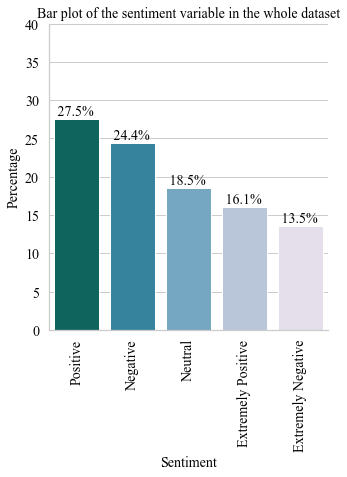

In [18]:
# We draw the barplot of the variable sentiment in the whole dataset

l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_Sentiment.shape[0]):
   l.append({"Sentiment":freq_Sentiment.index[i], "percent":freq_Sentiment[i]})

# We transform this dictionnary into a dataframe
df_Sentiment = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df_Sentiment, palette = 'PuBuGn_r')

(g.set_axis_labels("Sentiment", "Percentage")
              .set_titles("{col_name} {col_var}")
              .set(ylim=(0, 40))
              .ax.set_title("Bar plot of the sentiment variable in the whole dataset"))

plt.xticks(rotation='vertical')

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    if len(str(p.get_height().round(1)))==4:
        txt = " " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)
    if len(str(p.get_height().round(1)))==3:
        txt = "  " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)

In [19]:
# Frequency of the sentiment variable in the train dataset
freq_Sentiment_train = TRAIN["Sentiment"].astype(str).value_counts(normalize=True)*100
freq_Sentiment_train

Positive              27.752266
Negative              24.095537
Neutral               18.740433
Extremely Positive    16.094468
Extremely Negative    13.317297
Name: Sentiment, dtype: float64

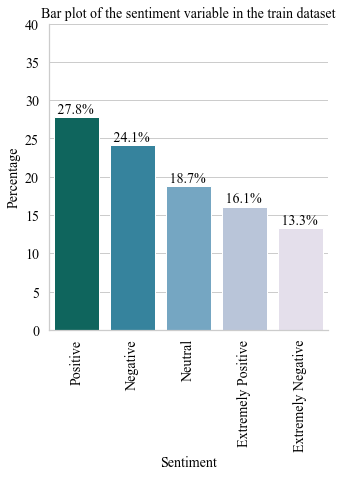

In [20]:
# We draw the barplot of the variable sentiment in the train dataset

l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_Sentiment_train.shape[0]):
   l.append({"Sentiment":freq_Sentiment_train.index[i], "percent":freq_Sentiment_train[i]})

# We transform this dictionnary into a dataframe
df_Sentiment_train = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df_Sentiment_train, palette = 'PuBuGn_r')

(g.set_axis_labels("Sentiment", "Percentage")
              .set_titles("{col_name} {col_var}")
              .set(ylim=(0, 40))
              .ax.set_title("Bar plot of the sentiment variable in the train dataset"))

plt.xticks(rotation='vertical')

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    if len(str(p.get_height().round(1)))==4:
        txt = " " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)
    if len(str(p.get_height().round(1)))==3:
        txt = "  " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)

In [21]:
# Frequency of the sentiment variable in the test dataset
freq_Sentiment_test = TEST["Sentiment"].astype(str).value_counts(normalize=True)*100
freq_Sentiment_test

Negative              27.409163
Positive              24.934176
Neutral               16.298052
Extremely Positive    15.771459
Extremely Negative    15.587151
Name: Sentiment, dtype: float64

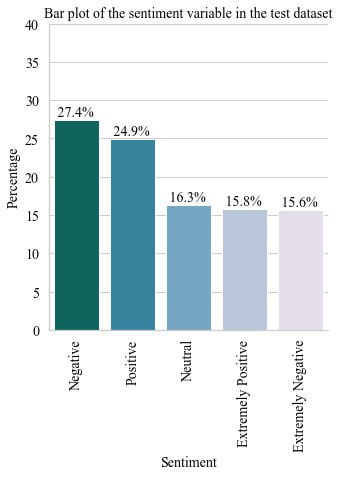

In [22]:
# We draw the barplot of the variable sentiment in the test dataset

l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_Sentiment_test.shape[0]):
   l.append({"Sentiment":freq_Sentiment_test.index[i], "percent":freq_Sentiment_test[i]})

# We transform this dictionnary into a dataframe
df_Sentiment_test = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df_Sentiment_test, palette = 'PuBuGn_r')

(g.set_axis_labels("Sentiment", "Percentage")
              .set_titles("{col_name} {col_var}")
              .set(ylim=(0, 40))
              .ax.set_title("Bar plot of the sentiment variable in the test dataset"))

plt.xticks(rotation='vertical')

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    if len(str(p.get_height().round(1)))==4:
        txt = " " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)
    if len(str(p.get_height().round(1)))==3:
        txt = "  " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)

## Evolution with time of the sentiment variable 

In [23]:
# We change the date format
df['TweetAt']=pd.to_datetime(df.TweetAt)

# Check what dates we have 
print(df['TweetAt'])

# Create a month variable 
df['Month'] = pd.DatetimeIndex(df['TweetAt']).month

0      2020-03-16
1      2020-03-16
2      2020-03-16
3      2020-03-16
4      2020-03-16
          ...    
3793   2020-03-16
3794   2020-03-16
3795   2020-03-16
3796   2020-03-16
3797   2020-03-16
Name: TweetAt, Length: 44955, dtype: datetime64[ns]


In [24]:
# We draw the superposition barplot of the variable sentiment with the entire data

counts = df["Month"].value_counts().sort_values(ascending=False)

df_month = df.loc[df["Month"].isin(counts.index)]
df_month = df.groupby(by=["Month","Sentiment"])["OriginalTweet"].count().reset_index(name="Count")

fig = px.bar(df_month, x='Month', y='Count', color='Sentiment', 
             title="Sentiment count each month", 
             color_discrete_sequence=["#F96C6C", "#F9B06C", "#F9F96C", "#AFF96C", "#3DF961"],
             category_orders={
                 "Month": ["January", "February", "March", "April", "May", "June", "July", "September",
                          "October", "November", "December"], 
                 "Sentiment": ["Extremely Negative", "Negative", "Neutral", "Positive", "Extremely Positive"]
             }
        )

fig.show()

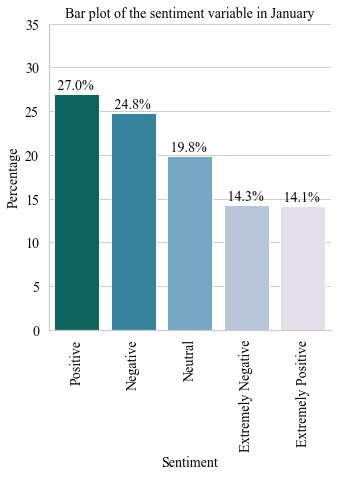

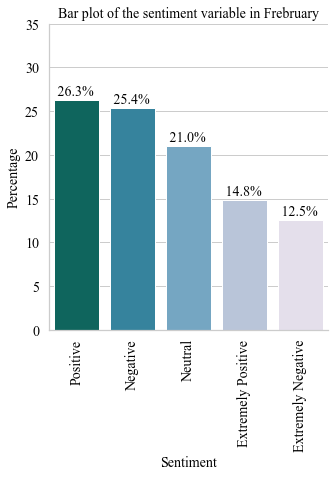

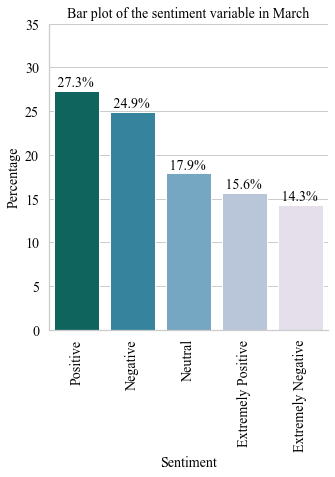

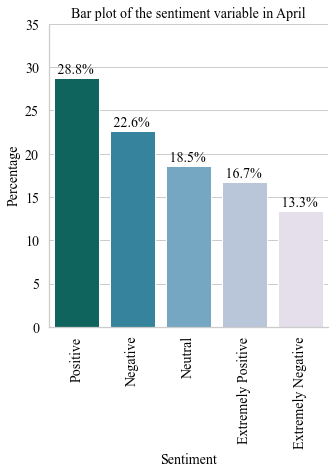

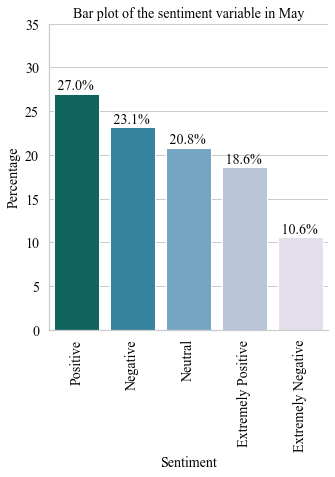

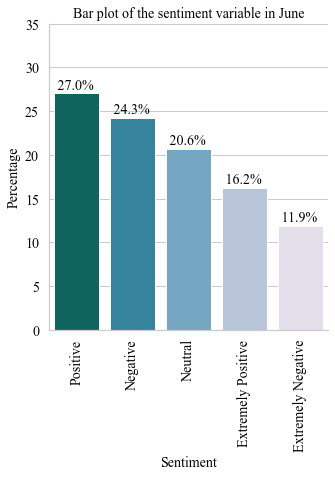

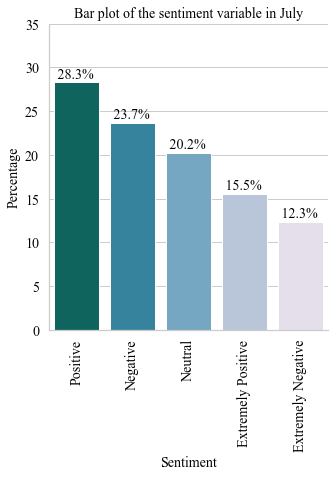

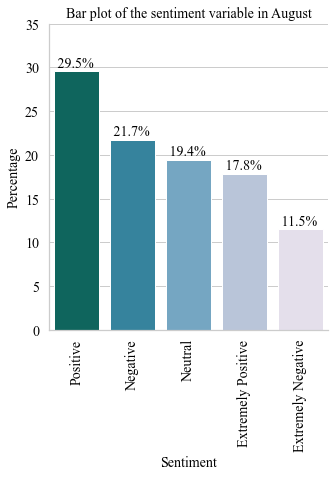

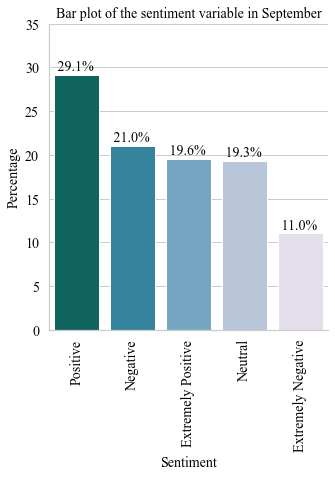

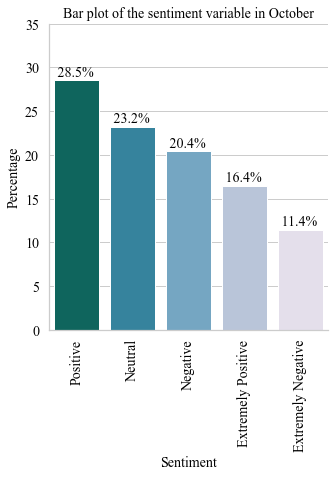

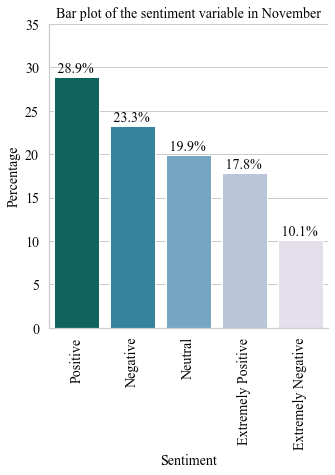

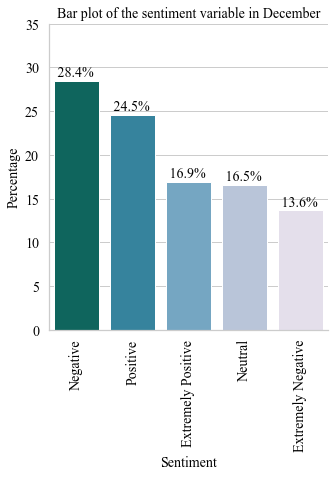

In [25]:
# We draw the barplot of the variable sentiment with the entire data

l1 = []
l2 = []
l3 = []
l4 = []
l5 = []
l6 = []
l7 = []
l8 = []
l9 = []
l10 = []
l11 = []
l12 = []

# We display the frequency of each modalities of the variable NB_LINES
Month1 = df["Sentiment"][df['Month']==1].astype(str).value_counts(normalize=True)*100
Month2 = df["Sentiment"][df['Month']==2].astype(str).value_counts(normalize=True)*100
Month3 = df["Sentiment"][df['Month']==3].astype(str).value_counts(normalize=True)*100
Month4 = df["Sentiment"][df['Month']==4].astype(str).value_counts(normalize=True)*100
Month5 = df["Sentiment"][df['Month']==5].astype(str).value_counts(normalize=True)*100
Month6 = df["Sentiment"][df['Month']==6].astype(str).value_counts(normalize=True)*100
Month7 = df["Sentiment"][df['Month']==7].astype(str).value_counts(normalize=True)*100
Month8 = df["Sentiment"][df['Month']==8].astype(str).value_counts(normalize=True)*100
Month9 = df["Sentiment"][df['Month']==9].astype(str).value_counts(normalize=True)*100
Month10 = df["Sentiment"][df['Month']==10].astype(str).value_counts(normalize=True)*100
Month11 = df["Sentiment"][df['Month']==11].astype(str).value_counts(normalize=True)*100
Month12 = df["Sentiment"][df['Month']==12].astype(str).value_counts(normalize=True)*100

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (Month1.shape[0]):
   l1.append({"Sentiment":Month1.index[i], "percent":Month1[i]})

for i in range (Month2.shape[0]):
   l2.append({"Sentiment":Month2.index[i], "percent":Month2[i]})

for i in range (Month3.shape[0]):
   l3.append({"Sentiment":Month3.index[i], "percent":Month3[i]})

for i in range (Month4.shape[0]):
   l4.append({"Sentiment":Month4.index[i], "percent":Month4[i]})

for i in range (Month5.shape[0]):
   l5.append({"Sentiment":Month5.index[i], "percent":Month5[i]})

for i in range (Month6.shape[0]):
   l6.append({"Sentiment":Month6.index[i], "percent":Month6[i]})

for i in range (Month7.shape[0]):
   l7.append({"Sentiment":Month7.index[i], "percent":Month7[i]})

for i in range (Month8.shape[0]):
   l8.append({"Sentiment":Month8.index[i], "percent":Month8[i]})

for i in range (Month9.shape[0]):
   l9.append({"Sentiment":Month9.index[i], "percent":Month9[i]})

for i in range (Month10.shape[0]):
   l10.append({"Sentiment":Month10.index[i], "percent":Month10[i]})

for i in range (Month11.shape[0]):
   l11.append({"Sentiment":Month11.index[i], "percent":Month11[i]})

for i in range (Month12.shape[0]):
   l12.append({"Sentiment":Month12.index[i], "percent":Month12[i]})

# We transform this dictionnary into a dataframe
df1 = pd.DataFrame(l1)
df2 = pd.DataFrame(l2)
df3 = pd.DataFrame(l3)
df4 = pd.DataFrame(l4)
df5 = pd.DataFrame(l5)
df6 = pd.DataFrame(l6)
df7 = pd.DataFrame(l7)
df8 = pd.DataFrame(l8)
df9 = pd.DataFrame(l9)
df10 = pd.DataFrame(l10)
df11 = pd.DataFrame(l11)
df12 = pd.DataFrame(l12)

# We plot the barplot (without the frequencies)
g1 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df1, palette = 'PuBuGn_r')

g2 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df2, palette = 'PuBuGn_r')

g3 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df3, palette = 'PuBuGn_r')

g4 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df4, palette = 'PuBuGn_r')

g5 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df5, palette = 'PuBuGn_r')

g6 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df6, palette = 'PuBuGn_r')

g7 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df7, palette = 'PuBuGn_r')

g8 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df8, palette = 'PuBuGn_r')

g9 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df9, palette = 'PuBuGn_r')

g10 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df10, palette = 'PuBuGn_r')

g11 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df11, palette = 'PuBuGn_r')

g12 = sns.catplot(x = "Sentiment", y = "percent", kind= 'bar',data = df12, palette = 'PuBuGn_r')

for dataframe in [g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12]:
    (dataframe.set_axis_labels("Sentiment", "Percentage")
              .set_titles("{col_name} {col_var}")
              .set(ylim=(0, 35))
              .ax.tick_params(axis='x', rotation=90))

# We add the frequencies at the top of each bar
for dataframe in [g1,g2,g3,g4,g5,g6,g7,g8,g9,g10,g11,g12]:
    for p in dataframe.ax.patches:
        if len(str(p.get_height().round(1)))==4:
            txt = " " + str(p.get_height().round(1)) + '%'
            txt_x = p.get_x()
            txt_y = p.get_height() + 0.5
            dataframe.ax.text(txt_x,txt_y,txt)
        if len(str(p.get_height().round(1)))==3:
            txt = "  " + str(p.get_height().round(1)) + '%'
            txt_x = p.get_x()
            txt_y = p.get_height() + 0.5
            dataframe.ax.text(txt_x,txt_y,txt)
        if dataframe==g1:
            dataframe.ax.set_title("Bar plot of the sentiment variable in January")
        if dataframe==g2:
            dataframe.ax.set_title("Bar plot of the sentiment variable in Frebruary")
        if dataframe==g3:
            dataframe.ax.set_title("Bar plot of the sentiment variable in March")
        if dataframe==g4:
            dataframe.ax.set_title("Bar plot of the sentiment variable in April")
        if dataframe==g5:
            dataframe.ax.set_title("Bar plot of the sentiment variable in May")
        if dataframe==g6:
            dataframe.ax.set_title("Bar plot of the sentiment variable in June")
        if dataframe==g7:
            dataframe.ax.set_title("Bar plot of the sentiment variable in July")
        if dataframe==g8:
            dataframe.ax.set_title("Bar plot of the sentiment variable in August")
        if dataframe==g9:
            dataframe.ax.set_title("Bar plot of the sentiment variable in September")
        if dataframe==g10:
            dataframe.ax.set_title("Bar plot of the sentiment variable in October")
        if dataframe==g11:
            dataframe.ax.set_title("Bar plot of the sentiment variable in November")
        if dataframe==g12:
            dataframe.ax.set_title("Bar plot of the sentiment variable in December")

## Quantitative elements that describe the dataset

* Group

In [26]:
# Frequency of the group variable 
freq_Group = df["Group"].astype(str).value_counts(normalize=True)*100
freq_Group

TRAIN    91.551552
TEST      8.448448
Name: Group, dtype: float64

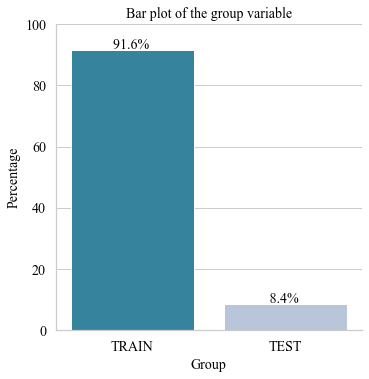

In [27]:
# We draw the barplot of the variable Group

l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_Group.shape[0]):
   l.append({"Group":freq_Group.index[i], "percent":freq_Group[i]})

# We transform this dictionnary into a dataframe
df_Group = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "Group", y = "percent", kind= 'bar',data = df_Group, palette = 'PuBuGn_r')

(g.set_axis_labels("Group", "Percentage")
              .set_titles("{col_name} {col_var}")
              .set(ylim=(0, 100))
              .ax.set_title("Bar plot of the group variable"))

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    if len(str(p.get_height().round(1)))==4:
        txt = "            " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)
    if len(str(p.get_height().round(1)))==3:
        txt = "             " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)

* Location

In [28]:
# Frequency of the location variable 
freq_Location = df["Location"].astype(str).value_counts(normalize=True)*100
freq_Location

nan                             20.963185
United States                    1.341341
London, England                  1.263486
London                           1.256812
New York, NY                     0.954288
                                  ...    
North Carolina and Michigan      0.002224
Tahlequah OK                     0.002224
Fremont, California, USA         0.002224
SÃ¥ lÃ¥ngt ifrÃ¥n, sÃ¥ nÃ¤ra     0.002224
Brooklyn & Queens                0.002224
Name: Location, Length: 13138, dtype: float64

* TweetAt

In [29]:
# Min and max dates
print(f'min: {df["TweetAt"].min()}')
print(f'max: {df["TweetAt"].max()}')

min: 2020-01-04 00:00:00
max: 2020-12-04 00:00:00


In [30]:
# Change numbers to months names

df['Month'][df['Month']==1]='January'
df['Month'][df['Month']==2]='February'
df['Month'][df['Month']==3]='March'
df['Month'][df['Month']==4]='April'
df['Month'][df['Month']==5]='May'
df['Month'][df['Month']==6]='June'
df['Month'][df['Month']==7]='July'
df['Month'][df['Month']==8]='August'
df['Month'][df['Month']==9]='September'
df['Month'][df['Month']==10]='October'
df['Month'][df['Month']==11]='November'
df['Month'][df['Month']==12]='December'

<ipython-input-30-7518f9d71f99>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [31]:
# Frequency of the Month variable 
freq_Time = df["Month"].astype(str).value_counts(normalize=True)*100
freq_Time

March        64.844845
April         5.532199
August        4.204204
July          4.115226
June          3.879435
December      3.309977
September     3.307752
May           2.529196
November      2.389056
October       2.355689
February      2.131020
January       1.401401
Name: Month, dtype: float64

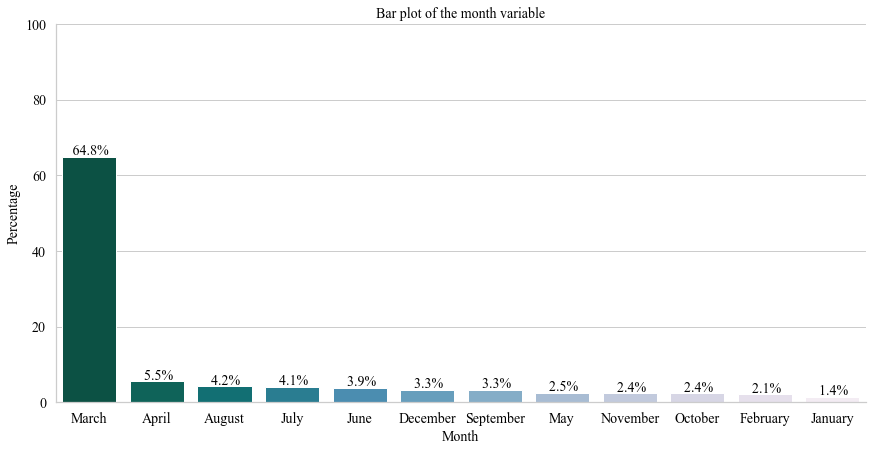

In [32]:
# We draw the barplot of the variable Month

l = []

# Creation of a dictionnary with the modalities and the frequency linked to the modalities
for i in range (freq_Time.shape[0]):
   l.append({"Month":freq_Time.index[i], "percent":freq_Time[i]})

# We transform this dictionnary into a dataframe
df_Time = pd.DataFrame(l)

# We plot the barplot (without the frequencies)
g = sns.catplot(x = "Month", y = "percent", kind= 'bar',data = df_Time, palette = 'PuBuGn_r', height=6, aspect=2)

(g.set_axis_labels("Month", "Percentage")
              .set_titles("{col_name} {col_var}")
              .set(ylim=(0, 100))
              .ax.set_title("Bar plot of the month variable"))

# We add the frequencies at the top of each bar
for p in g.ax.patches:
    if len(str(p.get_height().round(1)))==4:
        txt = "   " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)
    if len(str(p.get_height().round(1)))==3:
        txt = "    " + str(p.get_height().round(1)) + '%'
        txt_x = p.get_x()
        txt_y = p.get_height() + 0.5
        g.ax.text(txt_x,txt_y,txt)

## Clean the dataset with nltk

In [33]:
sw = stopwords.words('english')
new_sw = ['â', 'î', 'u','e']
sw.extend(new_sw)

In [34]:
# Copy of our data
df_clean=df.copy()

def convert_text_to_lowercase(df, colname):
    df[colname] = df[colname].str.lower()
    return df
    
def not_regex(pattern):
        return r"((?!{}).)".format(pattern)

def remove_punctuation(df, colname):
    df[colname] = df[colname].str.replace('\n', ' ')
    df[colname] = df[colname].str.replace('\r', ' ')
    alphanumeric_characters_extended = '(\\b[-/]\\b|[a-zA-Z0-9])'
    df[colname] = df[colname].str.replace(not_regex(alphanumeric_characters_extended), ' ')
    return df

def tokenize_sentence(df, colname):
    df[colname] = df[colname].str.split()
    return df

def remove_stop_words(df, colname):
    df[colname] = df[colname].apply(lambda x: [word for word in x if word not in sw])
    return df

def reverse_tokenize_sentence(df, colname):
    df[colname] = df[colname].map(lambda word: ' '.join(word))
    return df

def text_cleaning(df, colname):
    """
    Takes in a string of text, then performs the following:
    1. convert text to lowercase
    2. remove punctuation and new line characters '\n'
    3. Tokenize sentences
    4. Remove all stopwords
    5. convert tokenized text to text
    """
    df = (
        df
        .pipe(convert_text_to_lowercase, colname)
        .pipe(remove_punctuation, colname)
        .pipe(tokenize_sentence, colname)
        .pipe(remove_stop_words, colname)
        .pipe(reverse_tokenize_sentence, colname)
    )
    return df

In [35]:
# Apply the cleaning on our data
text_cleaning(df_clean, 'OriginalTweet')

<ipython-input-34-df901eb52060>:15: FutureWarning:

The default value of regex will change from True to False in a future version.



UserName  ScreenName             Location    TweetAt  \
0         3799       48751               London 2020-03-16   
1         3800       48752                   UK 2020-03-16   
2         3801       48753            Vagabonds 2020-03-16   
3         3802       48754                  NaN 2020-03-16   
4         3803       48755                  NaN 2020-03-16   
...        ...         ...                  ...        ...   
3793      3794       48746            Israel ?? 2020-03-16   
3794      3795       48747       Farmington, NM 2020-03-16   
3795      3796       48748        Haverford, PA 2020-03-16   
3796      3797       48749                  NaN 2020-03-16   
3797      3798       48750  Arlington, Virginia 2020-03-16   

                                          OriginalTweet           Sentiment  \
0     menyrbie phil gahan chrisitv https co/ifz9fan2...             Neutral   
1     advice talk neighbours family exchange phone n...            Positive   
2     coronavirus australia woolworths give elderly ...            Positive   
3     food stock one empty please panic enough food ...            Positive   
4     ready go supermarket covid19 outbreak paranoid...  Extremely Negative   
...                                                 ...                 ...   
3793  meanwhile supermarket israel people dance sing...            Positive   
3794  panic buy lot non-perishable items echo needs ...            Negative   
3795  asst prof economics cconces nbcphiladelphia ta...             Neutral   
3796  gov need somethings instead biar je rakyat ass...  Extremely Negative   
3797  forestandpaper members committed safety employ...  Extremely Positive   

      Group  Month  
0     TRAIN  March  
1     TRAIN  March  
2     TRAIN  March  
3     TRAIN  March  
4     TRAIN  March  
...     ...    ...  
3793   TEST  March  
3794   TEST  March  
3795   TEST  March  
3796   TEST  March  
3797   TEST  March  

[44955 rows x 8 columns]

In [36]:
def corpus(target):
    
    # remove urls
    target = re.sub(r'http\S+', " ", target)

    # remove mentions
    target = re.sub(r'@\S+',' ', target)

    # remove hastags
    target = re.sub(r'#\S+', ' ', target)

    # remove digits
    target = re.sub(r'\d+', ' ', target)

    # remove html tags
    target = re.sub('r<.*?>',' ', target)
    
    # remove co
    target = re.sub(r'co\S+', " ", target)
          
    return target

In [37]:
df_clean['OriginalTweet'] = df_clean['OriginalTweet'].apply(lambda x: corpus(x))
df_clean.head()

UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  menyrbie phil gahan chrisitv     fan pa     gh...             Neutral   
1  advice talk neighbours family exchange phone n...            Positive   
2    australia woolworths give elderly disabled d...            Positive   
3  food stock one empty please panic enough food ...            Positive   
4  ready go supermarket    outbreak paranoid food...  Extremely Negative   

   Group  Month  
0  TRAIN  March  
1  TRAIN  March  
2  TRAIN  March  
3  TRAIN  March  
4  TRAIN  March

In [38]:
# Apply the cleaning on our data
text_cleaning(df_clean, 'OriginalTweet')

<ipython-input-34-df901eb52060>:15: FutureWarning:

The default value of regex will change from True to False in a future version.



UserName  ScreenName             Location    TweetAt  \
0         3799       48751               London 2020-03-16   
1         3800       48752                   UK 2020-03-16   
2         3801       48753            Vagabonds 2020-03-16   
3         3802       48754                  NaN 2020-03-16   
4         3803       48755                  NaN 2020-03-16   
...        ...         ...                  ...        ...   
3793      3794       48746            Israel ?? 2020-03-16   
3794      3795       48747       Farmington, NM 2020-03-16   
3795      3796       48748        Haverford, PA 2020-03-16   
3796      3797       48749                  NaN 2020-03-16   
3797      3798       48750  Arlington, Virginia 2020-03-16   

                                          OriginalTweet           Sentiment  \
0     menyrbie phil gahan chrisitv fan pa ghgfzcc nl...             Neutral   
1     advice talk neighbours family exchange phone n...            Positive   
2     australia woolworths give elderly disabled ded...            Positive   
3     food stock one empty please panic enough food ...            Positive   
4     ready go supermarket outbreak paranoid food st...  Extremely Negative   
...                                                 ...                 ...   
3793  meanwhile supermarket israel people dance sing...            Positive   
3794  panic buy lot non-perishable items echo needs ...            Negative   
3795  asst prof c nbcphiladelphia talking recent res...             Neutral   
3796  gov need somethings instead biar je rakyat ass...  Extremely Negative   
3797  forestandpaper members safety employees end-us...  Extremely Positive   

      Group  Month  
0     TRAIN  March  
1     TRAIN  March  
2     TRAIN  March  
3     TRAIN  March  
4     TRAIN  March  
...     ...    ...  
3793   TEST  March  
3794   TEST  March  
3795   TEST  March  
3796   TEST  March  
3797   TEST  March  

[44955 rows x 8 columns]

In [39]:
# See cleaned data
df_clean.head(5)

UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  menyrbie phil gahan chrisitv fan pa ghgfzcc nl...             Neutral   
1  advice talk neighbours family exchange phone n...            Positive   
2  australia woolworths give elderly disabled ded...            Positive   
3  food stock one empty please panic enough food ...            Positive   
4  ready go supermarket outbreak paranoid food st...  Extremely Negative   

   Group  Month  
0  TRAIN  March  
1  TRAIN  March  
2  TRAIN  March  
3  TRAIN  March  
4  TRAIN  March

## Cloud of words

(-0.5, 999.5, 665.5, -0.5)

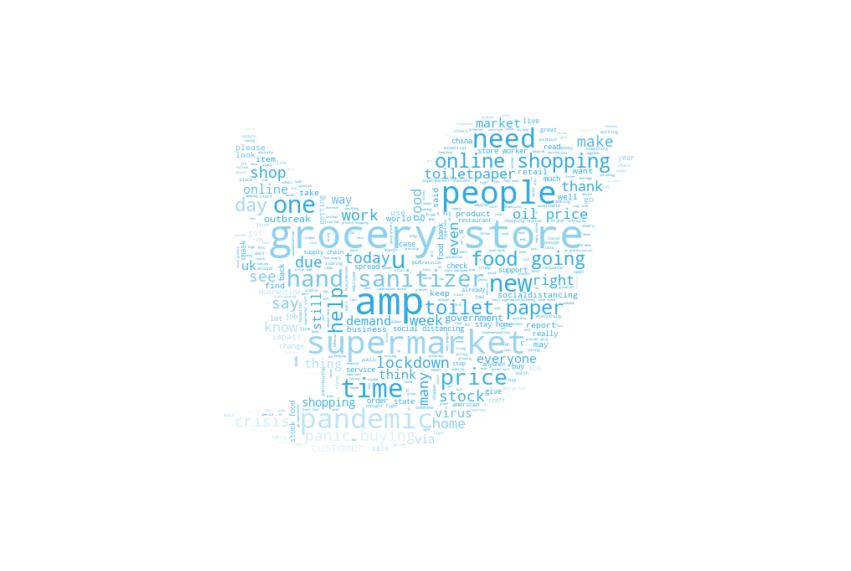

In [40]:
mask = np.array(Image.open(path_image+"twitter_logo_640.jpg"))
text = str(" ".join(word for word in df_clean['OriginalTweet']))
# Create and generate a word cloud image
wc_f = WordCloud(width = 500, height = 500, background_color="white", 
                      max_words=500, mask=mask).generate(text)

# Display the generated image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wc_f.recolor(color_func=image_colors), interpolation="bilinear")
plt.axis("off")

## Most frequent words used in tweets according to the sentiment expressed

* Positive

(-0.5, 999.5, 665.5, -0.5)

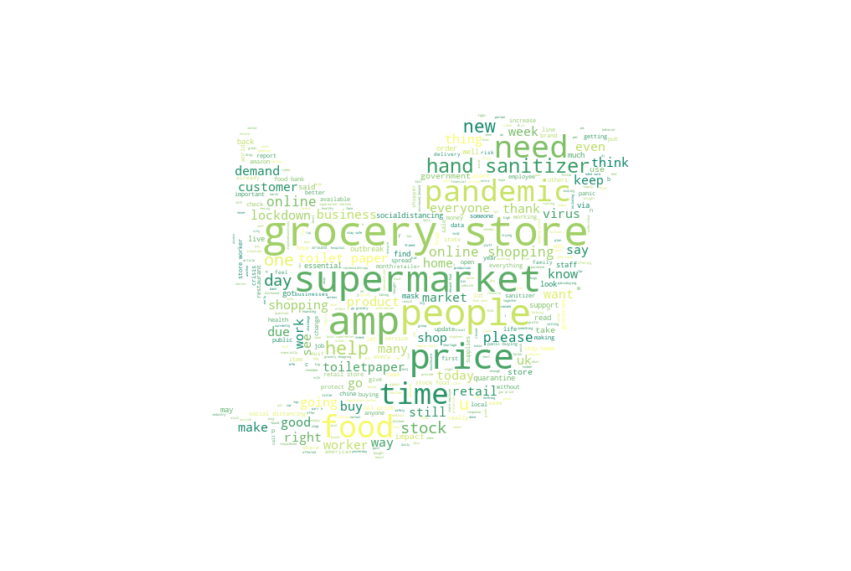

In [41]:
mask = np.array(Image.open(path_image+"twitter_logo_640.jpg"))
text = str(" ".join(word for word in df_clean['OriginalTweet'][df_clean['Sentiment']=='Positive']))
# Create and generate a word cloud image
wc_P = WordCloud(width = 500, height = 500, background_color="white", 
                      max_words=500, mask=mask, colormap="summer_r").generate(text)

# Display the generated image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wc_P, interpolation="bilinear")
plt.axis("off")

* Negative

(-0.5, 999.5, 665.5, -0.5)

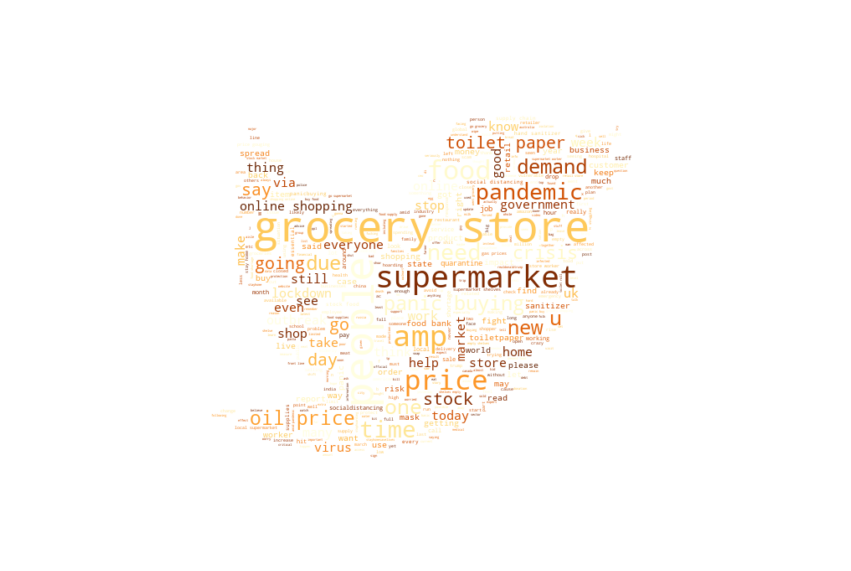

In [42]:
mask = np.array(Image.open(path_image+"twitter_logo_640.jpg"))
text = str(" ".join(word for word in df_clean['OriginalTweet'][df_clean['Sentiment']=='Negative']))
# Create and generate a word cloud image
wc_N = WordCloud(width = 500, height = 500, background_color="white", 
                      max_words=500, mask=mask, colormap="YlOrBr").generate(text)

# Display the generated image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wc_N, interpolation="bilinear")
plt.axis("off")

* Neutral

(-0.5, 999.5, 665.5, -0.5)

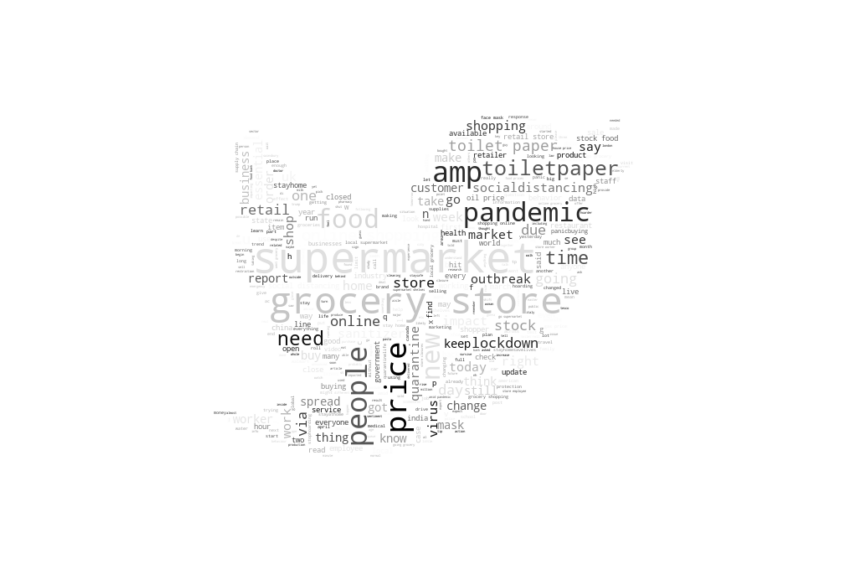

In [43]:
mask = np.array(Image.open(path_image+"twitter_logo_640.jpg"))
text = str(" ".join(word for word in df_clean['OriginalTweet'][df_clean['Sentiment']=='Neutral']))
# Create and generate a word cloud image
wc_NT = WordCloud(width = 500, height = 500, background_color="white", 
                      max_words=500, mask=mask, colormap="Greys_r").generate(text)

# Display the generated image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wc_NT, interpolation="bilinear")
plt.axis("off")

* Extremely Negative

(-0.5, 999.5, 665.5, -0.5)

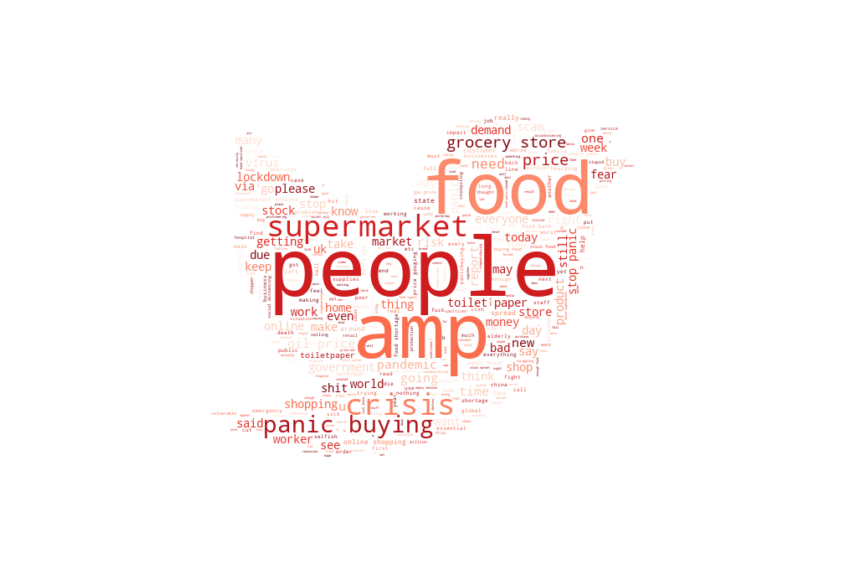

In [44]:
mask = np.array(Image.open(path_image+"twitter_logo_640.jpg"))
text = str(" ".join(word for word in df_clean['OriginalTweet'][df_clean['Sentiment']=='Extremely Negative']))
# Create and generate a word cloud image
wc_EN = WordCloud(width = 500, height = 500, background_color="white", 
                      max_words=500, mask=mask, colormap="Reds_r").generate(text)

# Display the generated image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wc_EN, interpolation="bilinear")
plt.axis("off")

* Extremely positive

(-0.5, 999.5, 665.5, -0.5)

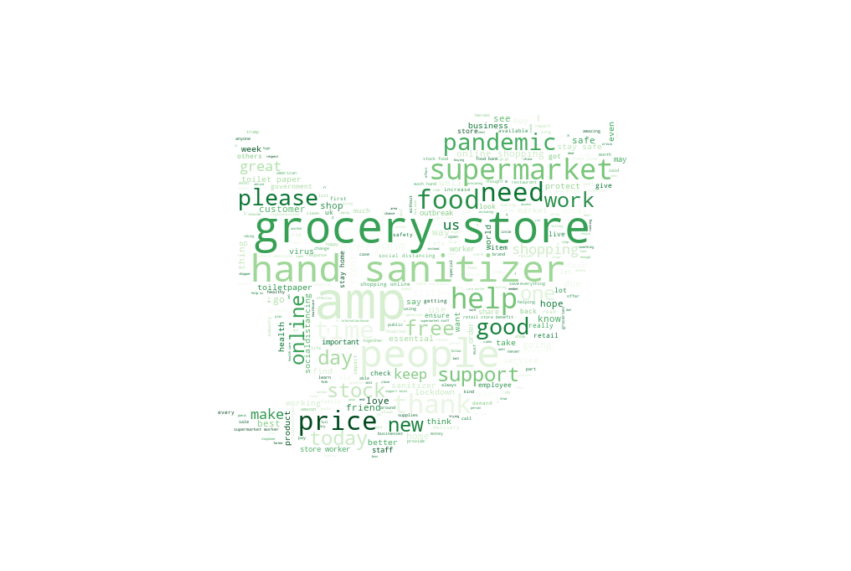

In [45]:
mask = np.array(Image.open(path_image+"twitter_logo_640.jpg"))
text = str(" ".join(word for word in df_clean['OriginalTweet'][df_clean['Sentiment']=='Extremely Positive']))
# Create and generate a word cloud image
wc_EP = WordCloud(width = 500, height = 500, background_color="white", 
                      max_words=500, mask=mask, colormap="Greens_r").generate(text)

# Display the generated image
image_colors = ImageColorGenerator(mask)
plt.figure(figsize=[15,15])
plt.imshow(wc_EP, interpolation="bilinear")
plt.axis("off")

##  Tractable dataset with tf-idf on the cleaned dataset

In [46]:
#Tf-idf

number_of_dimensions = 1000

# Vector representation of the text

tfidf_vectorizer = TfidfVectorizer(
    # Whether the feature should be made of word or character n-grams
    analyzer='word',
    # Unigrams: we consider one word by one word
    ngram_range=(1, 1),
    # Construct a vector the 1000 most used words
    max_features=number_of_dimensions,
    # Don't take the words that have a frequency higher than 100% 
    max_df=1.0,
    # Don't take the words that appear less than 10 times
    min_df=10)

tfidf_vectorizer.fit(df_clean['OriginalTweet'])

x_features = tfidf_vectorizer.transform(df_clean['OriginalTweet']).toarray()

# Clustering and topic identifcation

## Cluster the corpus

In [47]:
# To make the prediction and sentiment representation easier we reduce the number of classes to 3:
# Extremely Positive and Positive go together
# Extremely Negative and Negative go together

# We put codes to the Target variable (0 for neutral, 1 for negative and 2 for positive)

df_clean["Target"] = pd.DataFrame(df_clean["Sentiment"]).replace({"Sentiment": {"Extremely Positive" : "2", 
                             "Extremely Negative" : "1", "Positive" : "2", "Negative" : "1", "Neutral" : "0"}})
df_clean.head()

UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  menyrbie phil gahan chrisitv fan pa ghgfzcc nl...             Neutral   
1  advice talk neighbours family exchange phone n...            Positive   
2  australia woolworths give elderly disabled ded...            Positive   
3  food stock one empty please panic enough food ...            Positive   
4  ready go supermarket outbreak paranoid food st...  Extremely Negative   

   Group  Month Target  
0  TRAIN  March      0  
1  TRAIN  March      2  
2  TRAIN  March      2  
3  TRAIN  March      2  
4  TRAIN  March      1

In [48]:
n_clusters = 3
n_words = 10

In [49]:
# Kmeans algorithm
kmeans = KMeans(n_clusters=n_clusters, random_state=222, max_iter=10)

# Compute kmeans clustering
kmeans.fit(x_features)

# Get the labels for each tweet
df_clean["Cluster_km"]=kmeans.predict(x_features)
df_clean.head()

UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  menyrbie phil gahan chrisitv fan pa ghgfzcc nl...             Neutral   
1  advice talk neighbours family exchange phone n...            Positive   
2  australia woolworths give elderly disabled ded...            Positive   
3  food stock one empty please panic enough food ...            Positive   
4  ready go supermarket outbreak paranoid food st...  Extremely Negative   

   Group  Month Target  Cluster_km  
0  TRAIN  March      0           2  
1  TRAIN  March      2           1  
2  TRAIN  March      2           1  
3  TRAIN  March      2           2  
4  TRAIN  March      1           2

In [50]:
# Join the texts of each cluster

text_clusters_km = {k:"" for k in range (n_clusters)}
text_clusters_km

text_clusters_km[0] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_km']==0])
    
text_clusters_km[1] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_km']==1])

text_clusters_km[2] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_km']==2])

In [51]:
# Most common words for each cluster
for i, text in text_clusters_km.items():
    print(f"{n_words} most common words for cluster {i}:  {Counter(text.split()).most_common(n_words)}")
print()

10 most common words for cluster 0:  [('store', 7135), ('grocery', 6246), ('people', 1257), ('workers', 1256), ('retail', 936), ('go', 789), ('amp', 750), ('get', 733), ('like', 648), ('going', 620)]
10 most common words for cluster 1:  [('online', 3390), ('shopping', 3226), ('people', 458), ('amp', 433), ('delivery', 388), ('grocery', 372), ('home', 330), ('get', 273), ('food', 260), ('time', 237)]
10 most common words for cluster 2:  [('prices', 8306), ('food', 7604), ('supermarket', 7246), ('people', 4699), ('amp', 4624), ('pandemic', 2727), ('panic', 2688), ('stock', 2574), ('need', 2403), ('sanitizer', 2335)]



In [52]:
# Calculate Silhoutte Score

score = metrics.silhouette_score(x_features, kmeans.labels_, metric='euclidean')

score

0.010277716807398906

## Non-negative Matrix Factorization

In [53]:
# NMF Algorithm 
nmf = NMF(n_components=n_clusters, init='random')

# Compute nmf clustering
fit_nmf = nmf.fit_transform(x_features)
labels_nmf = np.argmax(fit_nmf, axis=1)

# Get the labels for each tweet
df_clean["Cluster_nmf"]=labels_nmf
df_clean.head()

UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  menyrbie phil gahan chrisitv fan pa ghgfzcc nl...             Neutral   
1  advice talk neighbours family exchange phone n...            Positive   
2  australia woolworths give elderly disabled ded...            Positive   
3  food stock one empty please panic enough food ...            Positive   
4  ready go supermarket outbreak paranoid food st...  Extremely Negative   

   Group  Month Target  Cluster_km  Cluster_nmf  
0  TRAIN  March      0           2            0  
1  TRAIN  March      2           1            1  
2  TRAIN  March      2           1            1  
3  TRAIN  March      2           2            1  
4  TRAIN  March      1           2            1

In [54]:
# Join the texts of each cluster

text_clusters_nmf = {k:"" for k in range (n_clusters)}
text_clusters_nmf

text_clusters_nmf[0] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_nmf']==0])
    
text_clusters_nmf[1] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_nmf']==1])

text_clusters_nmf[2] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_nmf']==2])

In [55]:
# Most common words for each cluster
for i, text in text_clusters_nmf.items():
    print(f"{n_words} most common words for cluster {i}:  {Counter(text.split()).most_common(n_words)}")
print()

10 most common words for cluster 0:  [('store', 7280), ('grocery', 6424), ('workers', 1366), ('people', 1164), ('retail', 1121), ('go', 776), ('amp', 732), ('get', 725), ('like', 647), ('going', 603)]
10 most common words for cluster 1:  [('food', 7569), ('supermarket', 7365), ('people', 4590), ('amp', 3895), ('shopping', 3709), ('online', 3581), ('panic', 2709), ('need', 2362), ('stock', 2302), ('sanitizer', 2171)]
10 most common words for cluster 2:  [('prices', 8154), ('oil', 1801), ('pandemic', 1460), ('amp', 1180), ('price', 899), ('due', 826), ('demand', 783), ('crisis', 775), ('us', 746), ('market', 713)]



## Soft-clustering with Latent Dirichlet Allocation

In [56]:
# Latent Dirichlet Allocation algorithm
lda = LatentDirichletAllocation(n_components=n_clusters, max_iter=10)

# Compute lda clustering
fit_lda = lda.fit_transform(x_features)
labels_lda = np.argmax(fit_lda, axis=1)

# Get the labels for each tweet
df_clean["Cluster_lda"]=labels_lda
df_clean.head()

UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  menyrbie phil gahan chrisitv fan pa ghgfzcc nl...             Neutral   
1  advice talk neighbours family exchange phone n...            Positive   
2  australia woolworths give elderly disabled ded...            Positive   
3  food stock one empty please panic enough food ...            Positive   
4  ready go supermarket outbreak paranoid food st...  Extremely Negative   

   Group  Month Target  Cluster_km  Cluster_nmf  Cluster_lda  
0  TRAIN  March      0           2            0            0  
1  TRAIN  March      2           1            1            0  
2  TRAIN  March      2           1            1            1  
3  TRAIN  March      2           2            1            1  
4  TRAIN  March      1           2            1            1

In [57]:
# Join the texts of each cluster

text_clusters_lda = {k:"" for k in range (n_clusters)}
text_clusters_lda

text_clusters_lda[0] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_lda']==0])
    
text_clusters_lda[1] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_lda']==1])

text_clusters_lda[2] =  ' '.join(df_clean['OriginalTweet'][df_clean['Cluster_lda']==2])

In [58]:
# Most common words for each cluster
for i, text in text_clusters_lda.items():
    print(f"{n_words} most common words for cluster {i}:  {Counter(text.split()).most_common(n_words)}")
print()

10 most common words for cluster 0:  [('store', 3358), ('grocery', 2892), ('supermarket', 2295), ('workers', 2020), ('amp', 1933), ('sanitizer', 1743), ('people', 1480), ('hand', 1373), ('home', 1069), ('food', 981)]
10 most common words for cluster 1:  [('supermarket', 4775), ('food', 4672), ('people', 4004), ('store', 3841), ('grocery', 3616), ('panic', 2403), ('shopping', 2192), ('get', 2123), ('amp', 1885), ('need', 1831)]
10 most common words for cluster 2:  [('prices', 5876), ('food', 2788), ('amp', 1989), ('demand', 1953), ('pandemic', 1846), ('oil', 1732), ('online', 1506), ('due', 1250), ('shopping', 1152), ('crisis', 1076)]



In [59]:
df_clean.head()

UserName  ScreenName   Location    TweetAt  \
0      3799       48751     London 2020-03-16   
1      3800       48752         UK 2020-03-16   
2      3801       48753  Vagabonds 2020-03-16   
3      3802       48754        NaN 2020-03-16   
4      3803       48755        NaN 2020-03-16   

                                       OriginalTweet           Sentiment  \
0  menyrbie phil gahan chrisitv fan pa ghgfzcc nl...             Neutral   
1  advice talk neighbours family exchange phone n...            Positive   
2  australia woolworths give elderly disabled ded...            Positive   
3  food stock one empty please panic enough food ...            Positive   
4  ready go supermarket outbreak paranoid food st...  Extremely Negative   

   Group  Month Target  Cluster_km  Cluster_nmf  Cluster_lda  
0  TRAIN  March      0           2            0            0  
1  TRAIN  March      2           1            1            0  
2  TRAIN  March      2           1            1            1  
3  TRAIN  March      2           2            1            1  
4  TRAIN  March      1           2            1            1

## Represent the sentiments according to the clusters

(-0.5, 399.5, 199.5, -0.5)

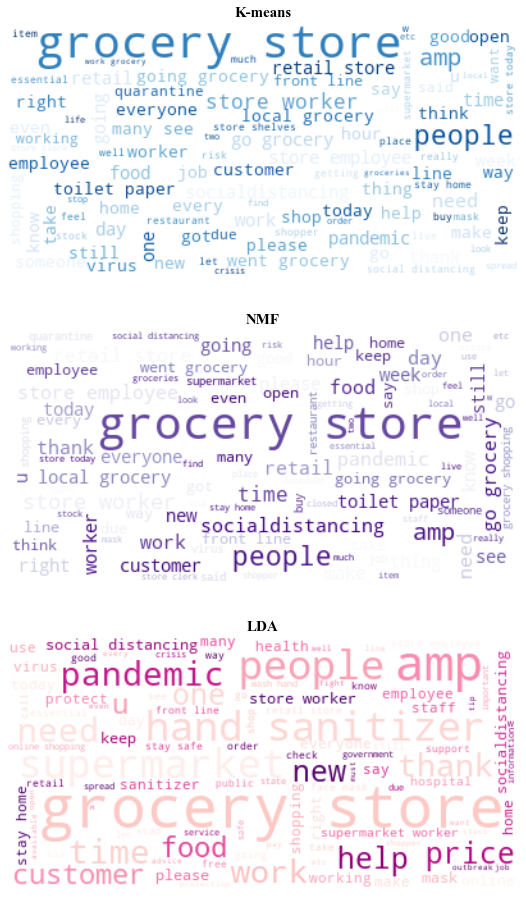

In [60]:
# WordClouds - Cluster 0
fig, axs = plt.subplots(3)

wordcloud = WordCloud(background_color='white', max_words=100, colormap="Blues_r").generate(text_clusters_km[0])
axs[0].set_title(f"K-means", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis("off") 

wordcloud = WordCloud(background_color='white', max_words=100, colormap="Purples_r").generate(text_clusters_nmf[0])
axs[1].set_title(f"NMF", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[1].imshow(wordcloud, interpolation='bilinear')
axs[1].axis("off") 

wordcloud = WordCloud(background_color='white', max_words=100, colormap="RdPu_r").generate(text_clusters_lda[0])
axs[2].set_title(f"LDA", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[2].imshow(wordcloud, interpolation='bilinear')
axs[2].axis("off") 

(-0.5, 399.5, 199.5, -0.5)

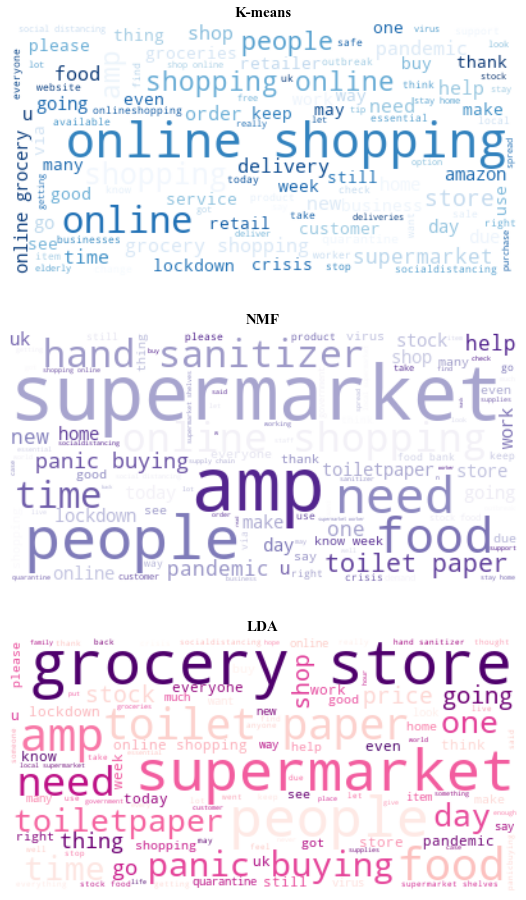

In [61]:
# WordClouds - Cluster 1
fig, axs = plt.subplots(3)

wordcloud = WordCloud(background_color='white', max_words=100, colormap="Blues_r").generate(text_clusters_km[1])
axs[0].set_title(f"K-means", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis("off") 

wordcloud = WordCloud(background_color='white', max_words=100, colormap="Purples_r").generate(text_clusters_nmf[1])
axs[1].set_title(f"NMF", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[1].imshow(wordcloud, interpolation='bilinear')
axs[1].axis("off") 

wordcloud = WordCloud(background_color='white', max_words=100, colormap="RdPu_r").generate(text_clusters_lda[1])
axs[2].set_title(f"LDA", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[2].imshow(wordcloud, interpolation='bilinear')
axs[2].axis("off") 

(-0.5, 399.5, 199.5, -0.5)

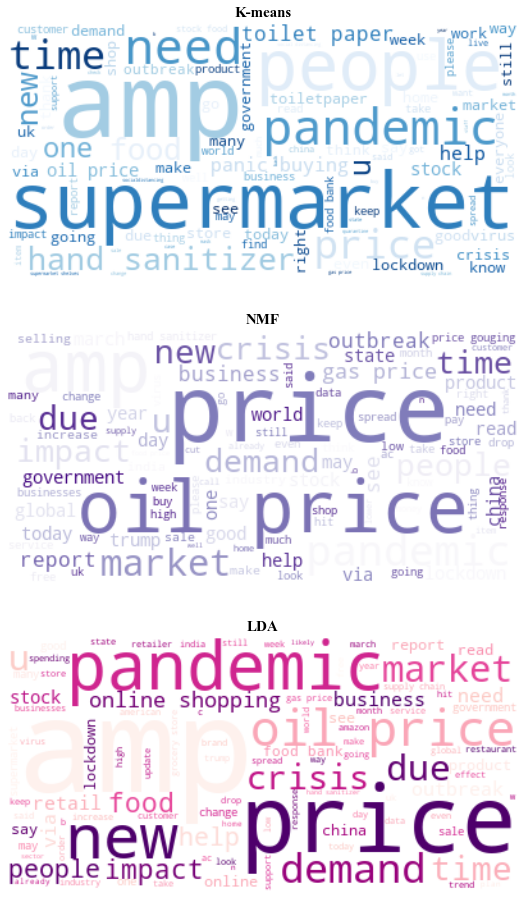

In [62]:
# WordClouds - Cluster 2
fig, axs = plt.subplots(3)

wordcloud = WordCloud(background_color='white', max_words=100, colormap="Blues_r").generate(text_clusters_km[2])
axs[0].set_title(f"K-means", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[0].imshow(wordcloud, interpolation='bilinear')
axs[0].axis("off") 

wordcloud = WordCloud(background_color='white', max_words=100, colormap="Purples_r").generate(text_clusters_nmf[2])
axs[1].set_title(f"NMF", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[1].imshow(wordcloud, interpolation='bilinear')
axs[1].axis("off") 

wordcloud = WordCloud(background_color='white', max_words=100, colormap="RdPu_r").generate(text_clusters_lda[2])
axs[2].set_title(f"LDA", fontdict = {'fontsize':15, 'fontweight':'bold'})
axs[2].imshow(wordcloud, interpolation='bilinear')
axs[2].axis("off") 

* Target frequency

In [63]:
df_clean["Target"].astype(str).value_counts()

2    19592
1    17031
0     8332
Name: Target, dtype: int64

* Frequencies k-means

In [64]:
df_clean["Target"][df_clean["Cluster_km"]==0].astype(str).value_counts()

2    3299
1    2335
0    1402
Name: Target, dtype: int64

In [65]:
df_clean["Target"][df_clean["Cluster_km"]==1].astype(str).value_counts()

2    1690
1     911
0     741
Name: Target, dtype: int64

In [66]:
df_clean["Target"][df_clean["Cluster_km"]==2].astype(str).value_counts()

2    14603
1    13785
0     6189
Name: Target, dtype: int64

* Frequencies nmf

In [67]:
df_clean["Target"][df_clean["Cluster_nmf"]==0].astype(str).value_counts()

2    3592
1    2468
0    1671
Name: Target, dtype: int64

In [68]:
df_clean["Target"][df_clean["Cluster_nmf"]==1].astype(str).value_counts()

2    12021
1     9711
0     4585
Name: Target, dtype: int64

In [69]:
df_clean["Target"][df_clean["Cluster_nmf"]==2].astype(str).value_counts()

1    4852
2    3979
0    2076
Name: Target, dtype: int64

* Frequencies lda

In [70]:
df_clean["Target"][df_clean["Cluster_lda"]==0].astype(str).value_counts()

2    6705
1    3298
0    2132
Name: Target, dtype: int64

In [71]:
df_clean["Target"][df_clean["Cluster_lda"]==1].astype(str).value_counts()

1    7822
2    7118
0    3208
Name: Target, dtype: int64

In [72]:
df_clean["Target"][df_clean["Cluster_lda"]==2].astype(str).value_counts()

1    5911
2    5769
0    2992
Name: Target, dtype: int64

# Sentiment analysis and inference

In [73]:
# We split the data again

train_clean=df_clean[df_clean['Group']=='TRAIN']
test_clean=df_clean[df_clean['Group']=='TEST']

In [74]:
# We define X_train, X_test, y_train and y_test 

X_train = tfidf_vectorizer.transform(train_clean['OriginalTweet']).toarray()
X_test = tfidf_vectorizer.transform(test_clean['OriginalTweet']).toarray()
Y_train = train_clean["Target"]
Y_test = test_clean["Target"]

## Support Vector Machine

In [75]:
# We use SVC
svc = svm.SVC(max_iter=1000)

# We train the data
svc.fit(X_train, Y_train)

# Predictions
pred_svc = svc.predict(X_test)

# Accuracy
svc_accuracy = metrics.accuracy_score(Y_test, pred_svc)

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning:

Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.



In [76]:
print("Training accuracy Score : ", svc.score(X_train,Y_train))
print("Testing accuracy Score  : ", svc_accuracy)
print(metrics.classification_report(pred_svc,Y_test))

Training accuracy Score :  0.5967150181014165
Testing accuracy Score  :  0.504739336492891
              precision    recall  f1-score   support

           0       0.53      0.26      0.35      1241
           1       0.46      0.62      0.53      1232
           2       0.54      0.63      0.58      1325

    accuracy                           0.50      3798
   macro avg       0.51      0.50      0.49      3798
weighted avg       0.51      0.50      0.49      3798



In [77]:
confusion_matrix(Y_test, pred_svc)

array([[326, 154, 139],
       [522, 758, 353],
       [393, 320, 833]])

## Optimized Support Vector Machine

In [78]:
# We use SVC
svc = svm.SVC(max_iter=300) # Max iter at 300 because it takes a long time 
parameters={'kernel':['linear','poly','rbf','sigmoid']}

svc_opti=GridSearchCV(svc, parameters)
# We train the data
svc_opti.fit(X_train, Y_train)

# Predictions
pred_svc_opti = svc_opti.predict(X_test)

# Accuracy
svc_accuracy_opti = metrics.accuracy_score(Y_test,pred_svc_opti)

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning:

Solver terminated early (max_iter=300).  Consider pre-processing your data with StandardScaler or MinMaxScaler.

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py:255: ConvergenceWarning:

Solver terminated early (max_iter=300)

In [79]:
print("Training accuracy Score : ", svc_opti.score(X_train,Y_train))
print("Testing accuracy Score  : ", svc_accuracy_opti)
print(metrics.classification_report(pred_svc_opti,Y_test))
print("Best parameter(s) :", svc_opti.best_params_)

Training accuracy Score :  0.4548679446995651
Testing accuracy Score  :  0.44971037388099
              precision    recall  f1-score   support

           0       0.40      0.20      0.27      1228
           1       0.53      0.57      0.55      1504
           2       0.39      0.56      0.46      1066

    accuracy                           0.45      3798
   macro avg       0.44      0.45      0.43      3798
weighted avg       0.45      0.45      0.43      3798

Best parameter(s) : {'kernel': 'sigmoid'}


In [80]:
confusion_matrix(Y_test, pred_svc_opti)

array([[249, 196, 174],
       [484, 858, 291],
       [495, 450, 601]])

## LSVC

In [81]:
# We use LSCV
linear_svc = svm.LinearSVC(max_iter=300)

# We train the data
linear_svc.fit(X_train,Y_train)

# Predictions
pred_linear_svc = linear_svc.predict(X_test)

# Accuracy
linear_svc_accuracy = metrics.accuracy_score(Y_test,pred_linear_svc)

print("Training accuracy Score   : ", linear_svc.score(X_train,Y_train))
print("Testing accuracy Score : ", linear_svc_accuracy)
print(metrics.classification_report(pred_linear_svc,Y_test))

Training accuracy Score   :  0.761887406759482
Testing accuracy Score :  0.7293312269615587
              precision    recall  f1-score   support

           0       0.62      0.57      0.59       676
           1       0.72      0.76      0.74      1549
           2       0.78      0.77      0.78      1573

    accuracy                           0.73      3798
   macro avg       0.71      0.70      0.70      3798
weighted avg       0.73      0.73      0.73      3798



In [82]:
confusion_matrix(Y_test, pred_linear_svc)

array([[ 383,  147,   89],
       [ 184, 1176,  273],
       [ 109,  226, 1211]])

## Optimized LSCV

In [83]:
# We use LSCV
lsvc = svm.LinearSVC(max_iter=300)
parameters={'penalty':['l1','l2'],
           'loss':['hinge','squared_hinge']}

lsvc_opti=GridSearchCV(lsvc, parameters)
lsvc_opti.fit(X_train,Y_train)

# Predictions
pred_lsvc_opti = lsvc_opti.predict(X_test)

# Accuracy
lsvc_accuracy_opti = metrics.accuracy_score(Y_test,pred_lsvc_opti)

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueE

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning:

Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_classes.py", line 234, in fit
    self.coef_, self.intercept_, self.n_iter_ = _fit_liblinear(
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 974, in _fit_liblinear
    solver_type = _get_liblinear_solver_type(multi_class, penalty, loss, dual)
  File "/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/svm/_base.py", line 830, in _get_liblinear_solver_type
    raise ValueError('Unsupported set of arguments: %s, '
ValueE

In [84]:
print("Training accuracy Score : ", lsvc_opti.score(X_train,Y_train))
print("Testing accuracy Score  : ", lsvc_accuracy_opti)
print(metrics.classification_report(pred_lsvc_opti,Y_test))
print(lsvc_opti.best_params_)

Training accuracy Score :  0.7640741550647521
Testing accuracy Score  :  0.735387045813586
              precision    recall  f1-score   support

           0       0.71      0.57      0.63       765
           1       0.71      0.78      0.74      1495
           2       0.77      0.78      0.78      1538

    accuracy                           0.74      3798
   macro avg       0.73      0.71      0.72      3798
weighted avg       0.74      0.74      0.73      3798

{'loss': 'hinge', 'penalty': 'l2'}


In [85]:
confusion_matrix(Y_test, pred_lsvc_opti)

array([[ 437,  108,   74],
       [ 207, 1159,  267],
       [ 121,  228, 1197]])

## SGDClassifier

In [86]:
#We use SGDClassifier
sgd = SGDClassifier(penalty="l2",
   max_iter=500)

# We train the data
sgd.fit(X_train,Y_train)

# Predictions
pred_sgd = sgd.predict(X_test)

# Accuracy
sgd_accuracy = metrics.accuracy_score(Y_test,pred_sgd)

In [87]:
print("Training accuracy Score   : ", sgd.score(X_train,Y_train))
print("Testing accuracy Score : ", sgd_accuracy)
print(metrics.classification_report(pred_sgd,Y_test))

Training accuracy Score   :  0.7542823820978205
Testing accuracy Score :  0.7243285939968405
              precision    recall  f1-score   support

           0       0.51      0.62      0.56       517
           1       0.73      0.74      0.74      1622
           2       0.80      0.74      0.77      1659

    accuracy                           0.72      3798
   macro avg       0.68      0.70      0.69      3798
weighted avg       0.73      0.72      0.73      3798



In [88]:
confusion_matrix(Y_test, pred_sgd)

array([[ 318,  181,  120],
       [ 127, 1200,  306],
       [  72,  241, 1233]])

## Optimized SGDClassifier

In [89]:
# We use SGDClassifier
sgd = SGDClassifier(max_iter=300, eta0=1)

# We train the data
parameters={'penalty':['l1','l2', 'elasticnet'],
           'learning_rate':['constant','optimal']}
sgd_opti=GridSearchCV(sgd, parameters)
sgd_opti.fit(X_train,Y_train)

# Predictions
pred_sgd_opti = sgd_opti.predict(X_test)

# Accuracy
sgd_accuracy_opti = metrics.accuracy_score(Y_test,pred_sgd_opti)

In [90]:
print("Training accuracy Score : ", sgd_opti.score(X_train,Y_train))
print("Testing accuracy Score  : ", sgd_accuracy_opti)
print(metrics.classification_report(pred_sgd_opti,Y_test))
print(sgd_opti.best_params_)

Training accuracy Score :  0.7576839905726851
Testing accuracy Score  :  0.7301211163770406
              precision    recall  f1-score   support

           0       0.74      0.55      0.63       840
           1       0.69      0.79      0.73      1427
           2       0.77      0.78      0.77      1531

    accuracy                           0.73      3798
   macro avg       0.73      0.70      0.71      3798
weighted avg       0.73      0.73      0.73      3798

{'learning_rate': 'optimal', 'penalty': 'l1'}


In [91]:
confusion_matrix(Y_test, pred_sgd_opti)

array([[ 461,   95,   63],
       [ 233, 1122,  278],
       [ 146,  210, 1190]])

## Gaussian Naive Bayes

In [92]:
# We use Gaussian Naive Bayes
clf = GaussianNB()

# We train the data
clf.fit(X_train,Y_train.values)

# Predictions
pred_clf = clf.predict(X_test)

# Accuracy
clf_accuracy = metrics.accuracy_score(Y_test,pred_clf)

print("Training accuracy Score   : ", clf.score(X_train,Y_train))
print("Testing accuracy Score : ", clf_accuracy)
print(metrics.classification_report(pred_clf,Y_test))

Training accuracy Score   :  0.6370483757319533
Testing accuracy Score :  0.6024223275408109
              precision    recall  f1-score   support

           0       0.78      0.38      0.51      1285
           1       0.55      0.71      0.62      1264
           2       0.59      0.73      0.65      1249

    accuracy                           0.60      3798
   macro avg       0.64      0.60      0.59      3798
weighted avg       0.64      0.60      0.59      3798



In [93]:
confusion_matrix(Y_test, pred_clf)

array([[485,  78,  56],
       [457, 893, 283],
       [343, 293, 910]])

## Optimized Gaussian Naive Bayes

In [94]:
# We use 
cf = GaussianNB()

# We train the data
parameters={'var_smoothing':np.arange(1e-9,1,0.1)}
cf_opti=GridSearchCV(cf, parameters)
cf_opti.fit(X_train,Y_train)

# Predictions
pred_cf_opti = cf_opti.predict(X_test)

# Accuracy
cf_accuracy_opti = metrics.accuracy_score(Y_test,pred_cf_opti)

In [95]:
print("Training accuracy Score : ", cf_opti.score(X_train,Y_train))
print("Testing accuracy Score  : ", cf_accuracy_opti)
print(metrics.classification_report(pred_cf_opti,Y_test))
print(cf_opti.best_params_)

Training accuracy Score :  0.6370483757319533
Testing accuracy Score  :  0.6024223275408109
              precision    recall  f1-score   support

           0       0.78      0.38      0.51      1285
           1       0.55      0.71      0.62      1264
           2       0.59      0.73      0.65      1249

    accuracy                           0.60      3798
   macro avg       0.64      0.60      0.59      3798
weighted avg       0.64      0.60      0.59      3798

{'var_smoothing': 1e-09}


In [96]:
confusion_matrix(Y_test, pred_cf_opti)

array([[485,  78,  56],
       [457, 893, 283],
       [343, 293, 910]])

## XGBoost

In [97]:
# We use XGBoost
XGB = XGBClassifier()

# We train the data
XGB.fit(X_train,Y_train)

# Predictions
pred_XGB = XGB.predict(X_test)

# Accuracy
XGB_accuracy = metrics.accuracy_score(Y_test,pred_XGB)

print("Training accuracy Score   : ", XGB.score(X_train,Y_train))
print("Testing accuracy Score : ", XGB_accuracy)
print(metrics.classification_report(pred_XGB,Y_test))

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning:

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].



[20:32:25] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Training accuracy Score   :  0.7831960541341692
Testing accuracy Score :  0.7209057398630858
              precision    recall  f1-score   support

           0       0.70      0.56      0.62       781
           1       0.69      0.76      0.72      1475
           2       0.76      0.76      0.76      1542

    accuracy                           0.72      3798
   macro avg       0.72      0.69      0.70      3798
weighted avg       0.72      0.72      0.72      3798



In [98]:
confusion_matrix(Y_test, pred_XGB)

array([[ 434,  114,   71],
       [ 214, 1126,  293],
       [ 133,  235, 1178]])

## NMF

In [99]:
# NMF Algorithm 
nmf = NMF(n_components=3, init='random')

# Compute nmf clustering
fit_nmf = nmf.fit(X_train)
pred_nmf=fit_nmf.transform(X_test)
labels_nmf = np.argmax(pred_nmf, axis=1)

In [100]:
nmf_accuracy = metrics.accuracy_score(Y_test,labels_nmf.astype(str))
print("Testing accuracy Score : ", nmf_accuracy)
print(metrics.classification_report(Y_test,labels_nmf.astype(str)))

Testing accuracy Score :  0.3404423380726698
              precision    recall  f1-score   support

           0       0.20      0.30      0.24       619
           1       0.27      0.03      0.05      1633
           2       0.39      0.68      0.50      1546

    accuracy                           0.34      3798
   macro avg       0.29      0.34      0.26      3798
weighted avg       0.31      0.34      0.27      3798



In [106]:
confusion_matrix(Y_test, labels_nmf.astype(str))

array([[ 186,   20,  413],
       [ 361,   49, 1223],
       [ 374,  114, 1058]])

## Decision Tree

In [101]:
# We use XGBoost
tr = tree.DecisionTreeClassifier()

# We train the data
tr.fit(X_train,Y_train)

# Predictions
pred_tr = tr.predict(X_test)

# Accuracy
tr_accuracy = metrics.accuracy_score(Y_test,pred_tr)

print("Training accuracy Score   : ", tr.score(X_train,Y_train))
print("Testing accuracy Score : ", tr_accuracy)
print(metrics.classification_report(pred_tr,Y_test))

Training accuracy Score   :  0.9952134509317978
Testing accuracy Score :  0.607161664033702
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       686
           1       0.60      0.64      0.62      1518
           2       0.67      0.65      0.66      1594

    accuracy                           0.61      3798
   macro avg       0.58      0.58      0.58      3798
weighted avg       0.61      0.61      0.61      3798



In [102]:
confusion_matrix(Y_test, pred_tr)

array([[ 301,  181,  137],
       [ 233,  974,  426],
       [ 152,  363, 1031]])

## Random Forest

In [103]:
# We use XGBoost
tr = tree.DecisionTreeClassifier()

# We train the data
tr.fit(X_train,Y_train)

# Predictions
pred_tr = tr.predict(X_test)

# Accuracy
tr_accuracy = metrics.accuracy_score(Y_test,pred_tr)

print("Training accuracy Score   : ", tr.score(X_train,Y_train))
print("Testing accuracy Score : ", tr_accuracy)
print(metrics.classification_report(pred_tr,Y_test))

Training accuracy Score   :  0.9952134509317978
Testing accuracy Score :  0.5997893628225381
              precision    recall  f1-score   support

           0       0.49      0.44      0.46       701
           1       0.59      0.64      0.61      1506
           2       0.66      0.64      0.65      1591

    accuracy                           0.60      3798
   macro avg       0.58      0.57      0.57      3798
weighted avg       0.60      0.60      0.60      3798



## Logistic regression classification

In [109]:
# We use A Logistic Regression as classifier
lr=LogisticRegression()

# We train the data
lr.fit(X_train,Y_train)

# Predictions
pred_lr = lr.predict(X_test)

# Accuracy
lr_accuracy = metrics.accuracy_score(Y_test,pred_lr)

print("Training accuracy Score   : ", lr.score(X_train,Y_train))
print("Testing accuracy Score : ", lr_accuracy)
print(metrics.classification_report(pred_lr,Y_test))

/Users/marie/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



Training accuracy Score   :  0.7604295745559686
Testing accuracy Score :  0.731437598736177
              precision    recall  f1-score   support

           0       0.58      0.59      0.58       617
           1       0.73      0.75      0.74      1586
           2       0.79      0.77      0.78      1595

    accuracy                           0.73      3798
   macro avg       0.70      0.70      0.70      3798
weighted avg       0.73      0.73      0.73      3798



In [110]:
confusion_matrix(Y_test, pred_lr)

array([[ 361,  164,   94],
       [ 161, 1194,  278],
       [  95,  228, 1223]])